In [35]:
import string

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Bidirectional, Dropout
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tf2crf import CRF, ModelWithCRFLoss
from keras.utils import to_categorical

import preprocess

In [2]:
# Fetch preprocesed data
static_df, formal_df = preprocess.fetch_preprocessed_data()
print(static_df.shape)
print(formal_df.shape)

# Concatenate static and formal samples
df = pd.concat([static_df, formal_df], ignore_index=True)
print(df.shape)
df

(21891, 4)
(3136, 4)
(25027, 4)


,words,tags,candidate,label
0,"[anyway, ,, thanks, mkm, and, keep, up, the, g...","[O, O, O, O, O, B-IDIOM, I-IDIOM, I-IDIOM, I-I...",keep up the good work,1
1,"[well, done, steffi, —, keep, up, the, good, w...","[O, O, O, O, B-IDIOM, I-IDIOM, I-IDIOM, I-IDIO...",keep up the good work,1
2,"[please, use, it, as, a, reminder, to, ensure,...","[O, O, O, O, O, O, O, O, O, O, B-IDIOM, I-IDIO...",keep up the good work,1
3,"[please, do, keep, up, the, good, work, .]","[O, O, B-IDIOM, I-IDIOM, I-IDIOM, I-IDIOM, I-I...",keep up the good work,1
4,"[we, hope, you, find, the, current, issue, sti...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-I...",keep up the good work,1
...,...,...,...,...
25022,"[this, year, marked, the, completion, and, ope...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",quantum leap,1
25023,"[a, quantum, leap, ahead, of, grace, bros, ', ...","[O, B-IDIOM, I-IDIOM, O, O, O, O, O, O, O, O, ...",quantum leap,1
25024,"[anybody, see, erm, quantum, leap, last, night...","[O, O, O, B-IDIOM, I-IDIOM, O, O, O]",quantum leap,1
25025,"[quantum, leap, in, microscopy]","[B-IDIOM, I-IDIOM, O, O]",quantum leap,1


In [3]:
# Find the maximum sentence length
df['sentence_length'] = df['words'].apply(len)
max_sentence_length = df['sentence_length'].max()
print("Maximum sentence length:", max_sentence_length)

Maximum sentence length: 751


In [4]:
# Print the longest sentence
longest_sentences = df[df['sentence_length'] == max_sentence_length]['words']
print(len(longest_sentences))  # Verify that there's exactly one longest sentence
print(" ".join(longest_sentences.iloc[0]))

1
yeah , well let me just read you two or three verses from exodus , chapter forty , this is what it says then the cloud covered the tent of meeting and the glory of the lord filled the tabernacle and moses was not able to enter the tent of meeting because the cloud had settled on it and the glory of the lord filled the tabernacle and throughout all their journeys whenever the cloud was taken up from over the tabernacle the sons of israel would set out , but if the cloud was not taken up then they did not set out until the day that it was taken up , for throughout all their journeys the cloud of the lord was on the tabernacle by day and there was fire in it by night , in the sight of all the house in israel and if you were to turn over to kings you have got a , you have got a similar thing there with the dedication of the temple and as be ben was saying the power really it 's the it 's the presence of god , the shine , the glory , that cloud of , and so what , what , what catches the l

Text(0.5, 1.0, 'Sentence Lengths')

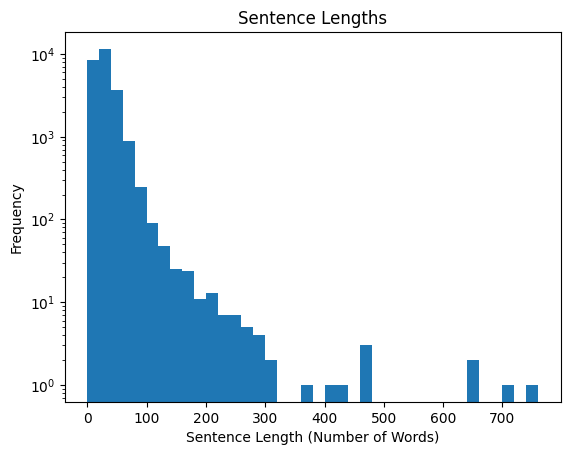

In [34]:
# Draw a histogram of sentence lengths, using log scale for the y-axis to better capture the outliers
binwidth = 20
plt.hist(df['sentence_length'], bins=np.arange(0, df['sentence_length'].max() + binwidth, binwidth))
plt.yscale("log")
plt.xlabel("Sentence Length (Number of Words)")
plt.ylabel("Frequency")
plt.title("Sentence Lengths")

In [6]:
# Print sentence lengths at various percentiles
print(np.percentile(df['sentence_length'], 90))
print(np.percentile(df['sentence_length'], 95))
print(np.percentile(df['sentence_length'], 98))
print(np.percentile(df['sentence_length'], 99))

50.0
61.0
79.0
99.0


In [7]:
# Print the top 20 longest sentences
df.sort_values(by='sentence_length', ascending=False).head(20)[["sentence_length", "words"]]

,sentence_length,words
14552,751,"[yeah, ,, well, let, me, just, read, you, two,..."
18205,710,"[the, letter, from, the, plaintiffs, solicitor..."
1818,641,"[you, make, your, sound, and, you, carry, on, ..."
1773,641,"[you, make, your, sound, and, you, carry, on, ..."
23280,468,"[a, word, gets, around, the, famine, is, over,..."
20733,468,"[nao, naomi, realizes, there, 's, no, point, t..."
13059,468,"[nao, naomi, realizes, there, 's, no, point, t..."
13010,422,"[if, that, power, was, sufficient, ,, the, hol..."
5187,410,"[well, my, pal, and, myself, we, took, these, ..."
15795,375,"[she, said, it, was, br, it, was, ,, i, did, n..."


In [8]:
# Print the first 100 words of the top 20 longest sentences to get a sense of their contents
for i, row in df.sort_values(by='sentence_length', ascending=False).head(20)[["sentence_length", "words"]].iterrows():
    sentence_length, words = row
    print(f"- {sentence_length}: {' '.join(words[:100])}...")

- 751: yeah , well let me just read you two or three verses from exodus , chapter forty , this is what it says then the cloud covered the tent of meeting and the glory of the lord filled the tabernacle and moses was not able to enter the tent of meeting because the cloud had settled on it and the glory of the lord filled the tabernacle and throughout all their journeys whenever the cloud was taken up from over the tabernacle the sons of israel would set out , but if the cloud was not taken up then they...
- 710: the letter from the plaintiffs solicitors in respect of question of interest one causes , the letter of the twenty ninth of january of nineteen ninety two , asking mr to confirm , that in addition to the settlement figure of forty two thousand pounds in respect of costs he 'd be paying interest until the date of payment , and er , there was never a mind that erm which find a reply to in , in thirtieth of march nineteen ninety two by mr , there 's no unqualified agreement in fig

In [9]:
# Print a random sample of 10 sentences for comparison
for i, row in df.sample(n=10)[["sentence_length", "words"]].iterrows():
    sentence_length, words = row
    print(f"- {sentence_length}: {' '.join(words[:100])}")

- 29: in the end i lost interest in my job , and the work at hand , and fell down on my efficiency and aptitude as a skilled man .
- 24: for the first time there were reports of german units refusing to ‘ go over the top ’ , or surrendering too easily .
- 50: the idea that anything can last for ever is nonsense , and if that 's what happens with kiss , then fair enough ; if it does not mean anything more to anyone than the time the band was functioning then that 's also perfectly fine with me . ’
- 51: and many of my staff in s in not just but one or two others , see this as the tail wagging the dog if you like where somebody says , you will do so and so , or you know , i 'm telling you you will do this .
- 24: if a coincidence of this magnitude happened to me , i should call it a miracle and would watch my language in future .
- 34: mr toshiki kaifu , japan 's prime minister , may still be a little wet behind the ears but , not for the first time , he has confounded his more experienc


The longest sentences in the dataset seem to be speech transcriptions that are missing punctuation between sentences, so they are actually not single sentences, but paragraphs / collections of sentences. Therefore, these sentences can be considered mostly noise and might hurt the performance of the model. In comparison, the random sample of sentences from the dataset appears to be much closer to what one would expect. Including the longest "sentences" in the dataset for the purposes of training the model would increase the encoded size of each input sample substantially, since the vectorized form of each sample will be padded to the length of the maximum sentence, which would drastically increase computational load. For these reasons, we will truncate the longest sentences to 100 words, which is at the 99th percentile of sentence lengths.

In [10]:
# We replace 'B-IDIOM' with 'I-IDIOM' in each sequence to simplify the input to the model.
# This way, the model does not have to learn that 'B-IDIOM' always comes at the beginning
# of an idiom, and we don't lose any information.
tags = df["tags"].apply(lambda row: ['I-IDIOM' if elt == 'B-IDIOM' else elt for elt in row])
tags

0        [O, O, O, O, O, I-IDIOM, I-IDIOM, I-IDIOM, I-I...
1        [O, O, O, O, I-IDIOM, I-IDIOM, I-IDIOM, I-IDIO...
2        [O, O, O, O, O, O, O, O, O, O, I-IDIOM, I-IDIO...
3        [O, O, I-IDIOM, I-IDIOM, I-IDIOM, I-IDIOM, I-I...
4        [O, O, O, O, O, O, O, O, O, O, O, O, O, O, I-I...
                               ...                        
25022    [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...
25023    [O, I-IDIOM, I-IDIOM, O, O, O, O, O, O, O, O, ...
25024                 [O, O, O, I-IDIOM, I-IDIOM, O, O, O]
25025                             [I-IDIOM, I-IDIOM, O, O]
25026    [I-IDIOM, I-IDIOM, O, O, O, O, O, O, O, O, O, ...
Name: tags, Length: 25027, dtype: object

In [11]:
df['text'] = df['words'].apply(lambda x: ' '.join(x))

In [12]:
# Maximum sentence length (longer ones will be truncated)
max_len = 100

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df["text"], tags, test_size=0.2, random_state=42)

In [13]:
def tokenize_and_pad(df, tokenizer):
    """Tokenize the rows of the dataframe using the given tokenizer and pad them to max_len."""
    return pad_sequences(tokenizer.texts_to_sequences(df), maxlen=max_len, padding='post', truncating='post')

# Tokenize the words
word_tokenizer = Tokenizer(lower=False)
word_tokenizer.fit_on_texts(X_train)
X_train_tokens = tokenize_and_pad(X_train, word_tokenizer)
X_test_tokens = tokenize_and_pad(X_test, word_tokenizer)

# Tokenize the tags
tag_tokenizer = Tokenizer(lower=False)
tag_tokenizer.fit_on_texts(y_train)
y_train_tokens = tokenize_and_pad(y_train, tag_tokenizer)
y_test_tokens = tokenize_and_pad(y_test, tag_tokenizer)

In [14]:
X_test_tokens

array([[19616,   230,     5, ...,     0,     0,     0],
       [    8,    14,    90, ...,     0,     0,     0],
       [   46,    22,    20, ...,     0,     0,     0],
       ...,
       [   55,    27,    38, ...,     0,     0,     0],
       [  191,    74,   122, ...,     0,     0,     0],
       [    1,   199,     2, ...,     0,     0,     0]], dtype=int32)

In [115]:
len(word_tokenizer.word_index)

31754

In [116]:
# Model architecture
input_tensor = Input(shape=(max_len,))
model = Embedding(input_dim=len(word_tokenizer.word_index) + 1, output_dim=50, input_length=max_len)(input_tensor)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
model = TimeDistributed(Dense(50, activation="relu"))(model)
crf = CRF(len(tag_tokenizer.word_index) + 1)  # CRF layer
out = crf(model)  # output

model = ModelWithCRFLoss(Model(input_tensor, out))

# Compile the model
model.compile(optimizer="adam")

In [118]:
# Train the model
history = model.fit(X_train_tokens, y_train_tokens, batch_size=32, epochs=5, validation_split=0.1, verbose=1)

Epoch 1/5
564/564 [==============================] - 106s 183ms/step - loss: 18.0768 - accuracy: 0.9408 - val_loss_val: 8.9804 - val_val_accuracy: 0.9664
Epoch 2/5
564/564 [==============================] - 109s 193ms/step - loss: 7.2805 - accuracy: 0.9717 - val_loss_val: 6.8699 - val_val_accuracy: 0.9722
Epoch 3/5
564/564 [==============================] - 110s 195ms/step - loss: 5.1705 - accuracy: 0.9785 - val_loss_val: 7.1192 - val_val_accuracy: 0.9734
Epoch 4/5
564/564 [==============================] - 111s 197ms/step - loss: 4.1156 - accuracy: 0.9825 - val_loss_val: 6.6316 - val_val_accuracy: 0.9743
Epoch 5/5
564/564 [==============================] - 109s 193ms/step - loss: 3.4449 - accuracy: 0.9853 - val_loss_val: 7.6037 - val_val_accuracy: 0.9735


In [119]:
# Evaluate the model
y_pred_tokens = model.predict(X_test_tokens)

157/157 [==============================] - 7s 44ms/step


In [121]:
y_test_tokens

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 2, 2, ..., 0, 0, 0]], dtype=int32)

In [122]:
y_pred_tokens

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 2, 2, ..., 0, 0, 0]], dtype=int32)

In [123]:
tag_tokenizer.word_index

{'O': 1, 'I-IDIOM': 2}

In [124]:
# We verify if all the sequences are valid according to the syntactical rules of the tagging
def verify_sequences(sequences_df):
    violations = []
    for i, sequence in enumerate(sequences_df):
        for j in range(len(sequence)):
            current_token = sequence[j]
            previous_token = sequence[j-1] if j > 0 else None

            # Only '0' can occur after '0'.
            if current_token != 0 and previous_token == 0:
                violations.append((i, j, "0"))
                continue

             # '0' cannot occur at the beginning.
            if current_token == 0 and previous_token is None:
                violations.append((i, j, "0"))
                continue

    return violations

violations = verify_sequences(y_pred_tokens)
print("Number of sequences that are not valid according to the rules:", len(violations))

Number of sequences that are not valid according to the rules: 3


In [125]:
violations

[(1129, 41, '0'), (1396, 41, '0'), (1409, 36, '0')]

There are a few instances (3, to be precise) where the model violated the syntactic structure of the tags, placing a '0', which represents padding at the end of a sentence, in the middle of a sentence. This is important to keep in mind as we iterate on the model design, but it shouldn't affect the evaluation for now.

In [126]:
y_pred_tokens[1129]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [127]:
y_test_tokens[1129]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [128]:
X_test

19653    guido took a mouthful of his whisky , his eyes...
14100    it 's two days ' journey to london by horse , ...
18456    so , with ‘ fly away peter ’ you lift up your ...
17647    duane jackson ( jeff bridges ) has survived ro...
397                                      no , never mind .
                               ...                        
6899     smyth — on the run for nine years — was jailed...
8241     down into his arteries and we can not get anyt...
17628    when they are in moult they often sit ashore o...
4024     does my right hon. friend agree that the launc...
15644    the north and south coasts are 14 miles equidi...
Name: text, Length: 5006, dtype: object

In [132]:
df.iloc[X_test.index]

,words,tags,candidate,label,sentence_length,text
19653,"[guido, took, a, mouthful, of, his, whisky, ,,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-IDIO...",over the top,1,20,"guido took a mouthful of his whisky , his eyes..."
14100,"[it, 's, two, days, ', journey, to, london, by...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-I...",all the way,1,18,"it 's two days ' journey to london by horse , ..."
18456,"[so, ,, with, ‘, fly, away, peter, ’, you, lif...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",out of sight,1,40,"so , with ‘ fly away peter ’ you lift up your ..."
17647,"[duane, jackson, (, jeff, bridges, ), has, sur...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",on the rocks,1,70,duane jackson ( jeff bridges ) has survived ro...
397,"[no, ,, never, mind, .]","[O, O, B-IDIOM, I-IDIOM, O]",never mind,1,5,"no , never mind ."
...,...,...,...,...,...,...
6899,"[smyth, —, on, the, run, for, nine, years, —, ...","[O, O, B-IDIOM, I-IDIOM, I-IDIOM, O, O, O, O, ...",on the run,1,24,smyth — on the run for nine years — was jailed...
8241,"[down, into, his, arteries, and, we, can, not,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",on the table,1,134,down into his arteries and we can not get anyt...
17628,"[when, they, are, in, moult, they, often, sit,...","[O, O, O, O, O, O, O, O, O, B-IDIOM, I-IDIOM, ...",on the rocks,1,25,when they are in moult they often sit ashore o...
4024,"[does, my, right, hon., friend, agree, that, t...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",under construction,1,45,does my right hon. friend agree that the launc...


In [155]:
IDIOM_TAG = 2

def mark_idioms(sentence_words, tags):
    # Truncate the tags list to the length of the sentence
    truncated_tags = tags[:len(sentence_words)]

    # Initialize variables
    marked_sentence = []
    in_idiom = False

    # Iterate over the words and their corresponding tags
    for i, (word, tag) in enumerate(zip(sentence_words, truncated_tags)):
        if tag == IDIOM_TAG and not in_idiom:
            # Mark the start of an idiom
            marked_sentence.append('**' + word)
            in_idiom = True
        elif in_idiom and (i == len(truncated_tags) - 1 or truncated_tags[i + 1] != IDIOM_TAG):
            # Mark the end of an idiom
            marked_sentence.append(word + '**')
            in_idiom = False
        else:
            # Add the word as it is
            marked_sentence.append(word)

    # Join the words back into a sentence
    return ' '.join(marked_sentence)


In [175]:
df.iloc[X_test.index]

,words,tags,candidate,label,sentence_length,text
19653,"[guido, took, a, mouthful, of, his, whisky, ,,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-IDIO...",over the top,1,20,"guido took a mouthful of his whisky , his eyes..."
14100,"[it, 's, two, days, ', journey, to, london, by...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-I...",all the way,1,18,"it 's two days ' journey to london by horse , ..."
18456,"[so, ,, with, ‘, fly, away, peter, ’, you, lif...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",out of sight,1,40,"so , with ‘ fly away peter ’ you lift up your ..."
17647,"[duane, jackson, (, jeff, bridges, ), has, sur...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",on the rocks,1,70,duane jackson ( jeff bridges ) has survived ro...
397,"[no, ,, never, mind, .]","[O, O, B-IDIOM, I-IDIOM, O]",never mind,1,5,"no , never mind ."
...,...,...,...,...,...,...
6899,"[smyth, —, on, the, run, for, nine, years, —, ...","[O, O, B-IDIOM, I-IDIOM, I-IDIOM, O, O, O, O, ...",on the run,1,24,smyth — on the run for nine years — was jailed...
8241,"[down, into, his, arteries, and, we, can, not,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",on the table,1,134,down into his arteries and we can not get anyt...
17628,"[when, they, are, in, moult, they, often, sit,...","[O, O, O, O, O, O, O, O, O, B-IDIOM, I-IDIOM, ...",on the rocks,1,25,when they are in moult they often sit ashore o...
4024,"[does, my, right, hon., friend, agree, that, t...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",under construction,1,45,does my right hon. friend agree that the launc...


In [156]:
# Includes all the columns (words, tags, candidate, etc.)
X_test_expanded = df.iloc[X_test.index].reset_index(drop=True)
X_test_expanded

,words,tags,candidate,label,sentence_length,text
0,"[guido, took, a, mouthful, of, his, whisky, ,,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-IDIO...",over the top,1,20,"guido took a mouthful of his whisky , his eyes..."
1,"[it, 's, two, days, ', journey, to, london, by...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-I...",all the way,1,18,"it 's two days ' journey to london by horse , ..."
2,"[so, ,, with, ‘, fly, away, peter, ’, you, lif...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",out of sight,1,40,"so , with ‘ fly away peter ’ you lift up your ..."
3,"[duane, jackson, (, jeff, bridges, ), has, sur...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",on the rocks,1,70,duane jackson ( jeff bridges ) has survived ro...
4,"[no, ,, never, mind, .]","[O, O, B-IDIOM, I-IDIOM, O]",never mind,1,5,"no , never mind ."
...,...,...,...,...,...,...
5001,"[smyth, —, on, the, run, for, nine, years, —, ...","[O, O, B-IDIOM, I-IDIOM, I-IDIOM, O, O, O, O, ...",on the run,1,24,smyth — on the run for nine years — was jailed...
5002,"[down, into, his, arteries, and, we, can, not,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",on the table,1,134,down into his arteries and we can not get anyt...
5003,"[when, they, are, in, moult, they, often, sit,...","[O, O, O, O, O, O, O, O, O, B-IDIOM, I-IDIOM, ...",on the rocks,1,25,when they are in moult they often sit ashore o...
5004,"[does, my, right, hon., friend, agree, that, t...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",under construction,1,45,does my right hon. friend agree that the launc...


In [157]:
for i in range(20):
    print(f"Sample {i} (label {X_test_expanded['label'][i]}, idiom '{X_test_expanded['candidate'][i]}'):")
    print(f"- Predicted: {mark_idioms(X_test_expanded['words'][i], y_pred_tokens[i])}")
    print(f"- Actual: {mark_idioms(X_test_expanded['words'][i], y_test_tokens[i])}")
    print()

Sample 0 (label 1, idiom 'over the top'):
- Predicted: guido took a mouthful of his whisky , his eyes **scanning her amusedly** over the top of his glass .
- Actual: guido took a mouthful of his whisky , his eyes scanning her amusedly **over the top** of his glass .

Sample 1 (label 1, idiom 'all the way'):
- Predicted: it 's two days ' journey to london by horse , and will **talked all the** way .
- Actual: it 's two days ' journey to london by horse , and will talked **all the way** .

Sample 2 (label 1, idiom 'out of sight'):
- Predicted: so , with ‘ fly away peter ’ you lift up your left hand and , as your fingers go **out of sight** behind your ears , you put away your index finger and bring out the second finger .
- Actual: so , with ‘ fly away peter ’ you lift up your left hand and , as your fingers go **out of sight** behind your ears , you put away your index finger and bring out the second finger .

Sample 3 (label 1, idiom 'on the rocks'):
- Predicted: duane jackson ( jeff b

Observations:
- The model successfully labels a substantial proportion of idioms.
- Sometimes, the model identifies phrases that could reasonably be interpreted as idioms, but that simply aren't the target idioms that are labeled in the sentence. For example, in sample 3, the model predicts "he's saddled [with debts of $12 million]" to be the idiom. This is not the literal use of the term "saddled," so it's reasonable to describe this as an idiom. However, the actual idiom is "[a marriage] on the rocks."
- The model often seems to predict idioms off by one word, e.g. "talked all the" instead of "all the way in sample 1. This reveals an issue with the tokenization - the dataset treats special characters as words, but the `Tokenizer` does not.
- Sometimes, the model doesn't recognize idioms that are either negative samples (literal use rather than idiomatic), or that are not as extreme examples of idioms. For example, in "areas that are often out of sight and out of mind," the model does not recognize the phrase "out of sight." The dataset only labels "out of sight" as an idiom, whereas the full idiom should probably be labeled as "out of sight and out of mind." The latter case can't really be helped, but for negative samples, we should probably add the label as an input to the model; otherwise, the model will have no way of knowing from the input data alone that a particular sample is negative, since the tagging does not reflect this.

Changes to be made:
- Fix the tokenization
- Add label as an input to the model, or better yet, update the tags for negative samples to no longer label them as idioms

# Fixing the preprocessing

In [15]:
X_train, X_test, y_train_tags, y_test_tags, y_train_labels, y_test_labels = train_test_split(
    df['text'], tags, df['label'], test_size=0.2, random_state=42)

def zero_out_tags(tags, labels):
    """Zeroes out tags for negative-labeled samples."""
    modified_tags = []
    for tag_sequence, label in zip(tags, labels):
        if label == 0:
            # Replace tag sequence with a sequence of 'O's
            modified_tags.append(['O'] * len(tag_sequence))
        else:
            modified_tags.append(tag_sequence)
    return modified_tags

# Modify the tags in training and test sets
y_train_tags_modified = zero_out_tags(y_train_tags, y_train_labels)
y_test_tags_modified = zero_out_tags(y_test_tags, y_test_labels)

y_train_tags_modified

[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-IDIOM', 'I-IDIOM', 'O'],
 ['O',
  'O',
  'O',
  'I-IDIOM',
  'I-IDIOM',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'I-IDIOM',
  'I-IDIOM',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'I-IDIOM',
  'I-IDIOM',
  'I-IDIOM',
  'O'],
 ['I-IDIOM', 'I-IDIOM', 'O', 'O', 'O', 'O'],
 ['O',
  'O',
  'O',
  'O',
  'I-IDIOM',
  'I-IDIOM',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O

In [16]:
# Set of standard characters
standard_chars = set(string.ascii_letters + string.digits + string.whitespace)

def find_special_chars(text):
    """Find special characters in a text."""
    return set(char for char in text if char not in standard_chars)

# Apply the function to each text entry in the X_train DataFrame and accumulate the results
special_chars = set()
X_train.apply(lambda x: special_chars.update(find_special_chars(x)))

print("Special characters found in the dataset:", sorted(special_chars))

Special characters found in the dataset: ['!', '"', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '=', '?', '[', ']', '_', '£', '¥', '¨', '°', '½', '¾', 'à', 'á', 'â', 'ä', 'å', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'í', 'ï', 'ñ', 'ò', 'ó', 'ô', 'ö', 'ø', 'ù', 'ü', 'ý', 'ā', 'ş', 'š', 'β', '–', '—', '‘', '’', '•', '…', '′', '″', '⅛']


In [17]:
# Default filters in Tokenizer, from https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
default_filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
default_filters_set = set(list(default_filters))

# Remove specific characters from the default filters
custom_filters_set = default_filters_set - special_chars

# Convert custom filters set to a string
custom_filters = "".join(sorted(custom_filters_set))
custom_filters

'\t\n#<>@\\^`{|}~'

In [18]:
# Tokenize the words
word_tokenizer = Tokenizer(lower=False, filters=custom_filters)
word_tokenizer.fit_on_texts(X_train)
X_train_tokens = tokenize_and_pad(X_train, word_tokenizer)
X_test_tokens = tokenize_and_pad(X_test, word_tokenizer)

# Tokenize the tags
tag_tokenizer = Tokenizer(lower=False)
tag_tokenizer.fit_on_texts(y_train_tags_modified)
y_train_tokens = tokenize_and_pad(y_train_tags_modified, tag_tokenizer)
y_test_tokens = tokenize_and_pad(y_test_tags_modified, tag_tokenizer)

In [19]:
print(X_test_tokens[4])
print(y_test_tags_modified[4])
print(df.iloc[397])
# We confirm that the special characters are now included as their own words in the dataset, as evidenced by the fact that X_test_tokens[4] has five non-zero tokens.

[ 72   2  95 112   3   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
['O', 'O', 'I-IDIOM', 'I-IDIOM', 'O']
words                  [no, ,, never, mind, .]
tags               [O, O, B-IDIOM, I-IDIOM, O]
candidate                           never mind
label                                        1
sentence_length                              5
text                         no , never mind .
Name: 397, dtype: object


In [20]:
# We look for the first sentence in the test set whose label is 0, and verify that it has been zeroed out succesfully.
print(y_test_labels[y_test_labels == 0])
print(X_test[24822])
print([i for i, idx in enumerate(y_test_labels.index) if idx == 24822][0])
print(y_test_tags_modified[19])

24822    0
23681    0
23205    0
24436    0
24006    0
        ..
23685    0
24609    0
23292    0
22209    0
24960    0
Name: label, Length: 83, dtype: int64
in addition , the system , when compressed , allows for a greater circulation of air around the foot , keeping it cool and dry .
19
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [263]:
# Now, we create a new model and train it.

# Model architecture
input_tensor = Input(shape=(max_len,))
model = Embedding(input_dim=len(word_tokenizer.word_index) + 1, output_dim=50, input_length=max_len)(input_tensor)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
model = TimeDistributed(Dense(50, activation="relu"))(model)
crf = CRF(len(tag_tokenizer.word_index) + 1)  # CRF layer
out = crf(model)  # output

model = ModelWithCRFLoss(Model(input_tensor, out))

# Compile the model
model.compile(optimizer="adam")

In [264]:
X_train_tokens

array([[   29,    42,     4, ...,     0,     0,     0],
       [    1, 11659,   301, ...,     0,     0,     0],
       [   33,    65,    53, ...,     0,     0,     0],
       ...,
       [  133, 34136, 10867, ...,     0,     0,     0],
       [   39,    71,    10, ...,   134,   136,    71],
       [   18,    14,     7, ...,     0,     0,     0]], dtype=int32)

In [265]:
y_train_tokens

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 2, ..., 0, 0, 0]], dtype=int32)

In [266]:
# Train the model
history = model.fit(X_train_tokens, y_train_tokens, batch_size=32, epochs=5, validation_split=0.1, verbose=1)

Epoch 1/5
564/564 [==============================] - 101s 174ms/step - loss: 6.7263 - accuracy: 0.9740 - val_loss_val: 2.1210 - val_val_accuracy: 0.9904
Epoch 2/5
564/564 [==============================] - 104s 184ms/step - loss: 1.4303 - accuracy: 0.9935 - val_loss_val: 1.3810 - val_val_accuracy: 0.9936
Epoch 3/5
564/564 [==============================] - 101s 178ms/step - loss: 0.7753 - accuracy: 0.9966 - val_loss_val: 1.2547 - val_val_accuracy: 0.9941
Epoch 4/5
564/564 [==============================] - 86s 152ms/step - loss: 0.4858 - accuracy: 0.9979 - val_loss_val: 1.1485 - val_val_accuracy: 0.9943
Epoch 5/5
564/564 [==============================] - 86s 153ms/step - loss: 0.3371 - accuracy: 0.9985 - val_loss_val: 1.1724 - val_val_accuracy: 0.9943


In [267]:
# Evaluate the model
y_pred_tokens = model.predict(X_test_tokens)

157/157 [==============================] - 4s 27ms/step


In [268]:
y_test_tokens

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 2, 2, ..., 0, 0, 0]], dtype=int32)

In [269]:
y_pred_tokens

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 2, 2, ..., 0, 0, 0]], dtype=int32)

In [270]:
# We still see a few violations of the syntactic rules; that's fine.
verify_sequences(y_pred_tokens)

[(122, 98, '0'),
 (260, 99, '0'),
 (2019, 96, '0'),
 (3084, 28, '0'),
 (4580, 9, '0'),
 (4915, 99, '0')]

In [271]:
for i in range(20):
    print(f"Sample {i} (label {X_test_expanded['label'][i]}, idiom '{X_test_expanded['candidate'][i]}'):")
    print(f"- Predicted: {mark_idioms(X_test_expanded['words'][i], y_pred_tokens[i])}")
    print(f"- Actual: {mark_idioms(X_test_expanded['words'][i], y_test_tokens[i])}")
    print()

Sample 0 (label 1, idiom 'over the top'):
- Predicted: guido took a mouthful of his whisky , his eyes scanning **her amusedly over** the top of his glass .
- Actual: guido took a mouthful of his whisky , his eyes scanning her amusedly **over the top** of his glass .

Sample 1 (label 1, idiom 'all the way'):
- Predicted: it 's two days ' journey to london by horse , and will talked **all the way** .
- Actual: it 's two days ' journey to london by horse , and will talked **all the way** .

Sample 2 (label 1, idiom 'out of sight'):
- Predicted: so , with ‘ fly away peter ’ you lift up your left hand and , as your fingers go **out of sight** behind your ears , you put away your index finger and bring out the second finger .
- Actual: so , with ‘ fly away peter ’ you lift up your left hand and , as your fingers go **out of sight** behind your ears , you put away your index finger and bring out the second finger .

Sample 3 (label 1, idiom 'on the rocks'):
- Predicted: duane jackson ( jeff b

The updated model seems to do a better job of tagging idioms at the correct location. For example, the previous model incorrectly marked the idiom as "talked all the" in sample 1, whereas this model correctly marked the idiom as "all the way." This is an indication that the updated tokenization helped the model understand the data better. It's still not perfect, however. For example, the model still predicts sample 6 as "column all the" rather than "all the way," which is the same mistake it made in the previous iteration.

In [272]:
# Print the first 20 test samples with label 0
for x in [x for x in zip(range(len(X_test_expanded)), X_test_expanded['label'], X_test_expanded['candidate'], X_test_expanded['words']) if x[1] == 0][:20]:
    i = x[0]
    print(f"Sample {x[0]} (label {x[1]}, idiom '{x[2]}'):")
    print(f"- Predicted: {mark_idioms(x[3], y_pred_tokens[i])}")
    print(f"- Actual: {mark_idioms(x[3], y_test_tokens[i])}")
    print()

Sample 19 (label 0, idiom 'keep [pron] cool'):
- Predicted: in addition , the system , when compressed , allows for a greater circulation of air around the foot , **keeping it cool** and dry .
- Actual: in addition , the system , when compressed , allows for a greater circulation of air around the foot , keeping it cool and dry .

Sample 24 (label 0, idiom 'add fuel to [pron] fire'):
- Predicted: anya leans forward and adds more coal to the fire .
- Actual: anya leans forward and adds more coal to the fire .

Sample 186 (label 0, idiom 'watch [pron] mouth'):
- Predicted: he watched her mouth **fall open** like an idiot 's , while her hand let the brush clatter to the floor ; she fell sideways , whether in a real or assumed faint he did not know or care .
- Actual: he watched her mouth fall open like an idiot 's , while her hand let the brush clatter to the floor ; she fell sideways , whether in a real or assumed faint he did not know or care .

Sample 316 (label 0, idiom 'bite [pron] t

The model still struggles with classifying negative samples correctly. Sometimes it picks the literal usage of the candidate idiom phrase, sometimes it picks a phrase seemingly at random. It only answers correctly (by marking all the words as literal) in a small proportion of the samples, e.g. samples 24, 498, 567, 660, 666, 671. Again, as with the idiom classifier, some of the data is polluted by incorrect labeling, e.g. sample 785, which is labeled as a negative sample for the idiom "pig out," but which is actually an idiomatic usage of the phrase.

In [273]:
tag_tokenizer.index_word

{1: 'O', 2: 'I-IDIOM'}

In [27]:
# Flatten the arrays for analysis
y_test_tokens_flat = y_test_tokens.flatten()

In [274]:
y_pred_tokens_flat = y_pred_tokens.flatten()

In [276]:
# Calculate classification report
# Baseline model
report = classification_report(y_test_tokens_flat, y_pred_tokens_flat, labels=[0, 1, 2])
print(report)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    358971
           1       0.97      0.95      0.96    127119
           2       0.79      0.77      0.78     14510

    accuracy                           0.98    500600
   macro avg       0.92      0.90      0.91    500600
weighted avg       0.98      0.98      0.98    500600



In [283]:
num_classes = 3
y_train_onehot = to_categorical(y_train_tokens, num_classes=num_classes)
y_train_onehot

array([[[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        ...,
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        ...,
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        ...,
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       ...,

       [[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        ...,
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        ...,
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]],

       [[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        ...,
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]]], dtype=float32)

In [277]:
# Now, we will conduct an ablation study. We will remove the CRF layer of the model and see how it performs in comparison to the base model.
input_tensor = Input(shape=(max_len,))
model_no_crf = Embedding(input_dim=len(word_tokenizer.word_index) + 1, output_dim=50, input_length=max_len)(input_tensor)
model_no_crf = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model_no_crf)
out = TimeDistributed(Dense(len(tag_tokenizer.word_index) + 1, activation="softmax"))(model_no_crf)  # Use softmax for multi-class classification

model_no_crf = Model(input_tensor, out)
model_no_crf.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [290]:
tf.config.run_functions_eagerly(True)

In [291]:
history_no_crf = model_no_crf.fit(X_train_tokens, y_train_onehot, batch_size=32, epochs=5, validation_split=0.1, verbose=1)

Epoch 1/5


/Users/aaron.pradhan/work/platform/.venv/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


564/564 [==============================] - 353s 626ms/step - loss: 0.0679 - accuracy: 0.9789 - val_loss: 0.0269 - val_accuracy: 0.9901
Epoch 2/5
564/564 [==============================] - 350s 621ms/step - loss: 0.0185 - accuracy: 0.9933 - val_loss: 0.0169 - val_accuracy: 0.9939
Epoch 3/5
564/564 [==============================] - 347s 616ms/step - loss: 0.0105 - accuracy: 0.9963 - val_loss: 0.0147 - val_accuracy: 0.9948
Epoch 4/5
564/564 [==============================] - 355s 629ms/step - loss: 0.0071 - accuracy: 0.9976 - val_loss: 0.0156 - val_accuracy: 0.9948
Epoch 5/5
564/564 [==============================] - 340s 603ms/step - loss: 0.0053 - accuracy: 0.9982 - val_loss: 0.0168 - val_accuracy: 0.9947


In [292]:
# Evaluate the model
y_pred_tokens_no_crf = model_no_crf.predict(X_test_tokens)

/Users/aaron.pradhan/work/platform/.venv/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


157/157 [==============================] - 49s 309ms/step


In [300]:
y_pred_tokens_no_crf.shape

(5006, 100, 3)

In [301]:
y_pred_tokens_no_crf

array([[[6.2271079e-06, 9.9988973e-01, 1.0400153e-04],
        [2.3796447e-05, 9.9924767e-01, 7.2853558e-04],
        [5.8179708e-06, 9.9975461e-01, 2.3949334e-04],
        ...,
        [1.0000000e+00, 3.8785464e-09, 3.3034014e-10],
        [1.0000000e+00, 1.6595932e-08, 1.9528761e-09],
        [9.9999988e-01, 1.5552871e-07, 2.6417029e-08]],

       [[2.2026438e-06, 9.9996948e-01, 2.8369586e-05],
        [6.4803118e-07, 9.9998629e-01, 1.3154496e-05],
        [1.0325790e-06, 9.9997151e-01, 2.7469256e-05],
        ...,
        [1.0000000e+00, 3.8476879e-09, 3.3135106e-10],
        [1.0000000e+00, 1.6469325e-08, 1.9586133e-09],
        [9.9999988e-01, 1.5439169e-07, 2.6491907e-08]],

       [[2.9308426e-06, 9.9981159e-01, 1.8548660e-04],
        [4.1697118e-07, 9.9996924e-01, 3.0354286e-05],
        [5.1394778e-07, 9.9995971e-01, 3.9766506e-05],
        ...,
        [1.0000000e+00, 4.3430202e-09, 3.1813252e-10],
        [1.0000000e+00, 1.8509368e-08, 1.8832351e-09],
        [9.9999988e-01

In [302]:
y_pred_class = np.argmax(y_pred_tokens_no_crf, axis=-1)

In [303]:
# Flatten the array for analysis
y_pred_tokens_no_crf_flat = y_pred_class.flatten()

In [304]:
# Calculate classification report
# No CRF layer
report_no_crf = classification_report(y_test_tokens_flat, y_pred_tokens_no_crf_flat, labels=[0, 1, 2])
print(report_no_crf)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    358971
           1       0.98      0.95      0.96    127119
           2       0.79      0.77      0.78     14510

    accuracy                           0.98    500600
   macro avg       0.92      0.91      0.91    500600
weighted avg       0.98      0.98      0.98    500600



The performance of the model with no CRF layer is comparable to that of the model with a CRF layer. The model with the CRF layer is substantially faster to train, so we will stick with that going forward.

In [21]:
tf.config.run_functions_eagerly(False)

In [22]:
# We will conduct another ablation study to investigate the impact of the number of LSTM units.
# Model architecture - 200 LSTM units
input_tensor200 = Input(shape=(max_len,))
model200 = Embedding(input_dim=len(word_tokenizer.word_index) + 1, output_dim=50, input_length=max_len)(input_tensor200)
model200 = Bidirectional(LSTM(units=200, return_sequences=True, recurrent_dropout=0.1))(model200)
model200 = TimeDistributed(Dense(50, activation="relu"))(model200)
crf = CRF(len(tag_tokenizer.word_index) + 1)  # CRF layer
out = crf(model200)  # output

model200 = ModelWithCRFLoss(Model(input_tensor200, out))

# Compile the model
model200.compile(optimizer="adam")

In [23]:
history200 = model200.fit(X_train_tokens, y_train_tokens, batch_size=32, epochs=5, validation_split=0.1, verbose=1)

Epoch 1/5


2023-12-10 20:06:38.663289: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_BOOL
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond/output/_831'


564/564 [==============================] - 246s 432ms/step - loss: 5.8136 - accuracy: 0.9684 - val_loss_val: 2.1325 - val_val_accuracy: 0.9905
Epoch 2/5
564/564 [==============================] - 256s 454ms/step - loss: 1.2847 - accuracy: 0.9942 - val_loss_val: 1.1899 - val_val_accuracy: 0.9945
Epoch 3/5
564/564 [==============================] - 255s 452ms/step - loss: 0.6532 - accuracy: 0.9970 - val_loss_val: 1.0077 - val_val_accuracy: 0.9951
Epoch 4/5
564/564 [==============================] - 259s 458ms/step - loss: 0.4064 - accuracy: 0.9981 - val_loss_val: 1.0482 - val_val_accuracy: 0.9948
Epoch 5/5
564/564 [==============================] - 241s 427ms/step - loss: 0.2932 - accuracy: 0.9986 - val_loss_val: 0.9485 - val_val_accuracy: 0.9952


In [24]:
# Evaluate the model
y_pred_tokens200 = model200.predict(X_test_tokens)

157/157 [==============================] - 13s 79ms/step


In [25]:
# Flatten the array for analysis
y_pred_tokens200_flat = y_pred_tokens200.flatten()

In [28]:
# Calculate classification report
# 200 LSTM units
report200 = classification_report(y_test_tokens_flat, y_pred_tokens200_flat, labels=[0, 1, 2])
print(report200)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    358971
           1       0.97      0.95      0.96    127119
           2       0.79      0.77      0.78     14510

    accuracy                           0.98    500600
   macro avg       0.92      0.90      0.91    500600
weighted avg       0.98      0.98      0.98    500600



In [30]:
# Model architecture - 50 LSTM units
input_tensor50 = Input(shape=(max_len,))
model50 = Embedding(input_dim=len(word_tokenizer.word_index) + 1, output_dim=50, input_length=max_len)(input_tensor50)
model50 = Bidirectional(LSTM(units=50, return_sequences=True, recurrent_dropout=0.1))(model50)
model50 = TimeDistributed(Dense(50, activation="relu"))(model50)
crf = CRF(len(tag_tokenizer.word_index) + 1)  # CRF layer
out = crf(model50)  # output

model50 = ModelWithCRFLoss(Model(input_tensor50, out))

# Compile the model
model50.compile(optimizer="adam")

In [31]:
history50 = model50.fit(X_train_tokens, y_train_tokens, batch_size=32, epochs=5, validation_split=0.1, verbose=1)

Epoch 1/5
564/564 [==============================] - 53s 89ms/step - loss: 8.8542 - accuracy: 0.9621 - val_loss_val: 2.5143 - val_val_accuracy: 0.9914
Epoch 2/5
564/564 [==============================] - 52s 93ms/step - loss: 1.6766 - accuracy: 0.9940 - val_loss_val: 1.7674 - val_val_accuracy: 0.9937
Epoch 3/5
564/564 [==============================] - 50s 89ms/step - loss: 0.8997 - accuracy: 0.9968 - val_loss_val: 1.5431 - val_val_accuracy: 0.9947
Epoch 4/5
564/564 [==============================] - 49s 88ms/step - loss: 0.5749 - accuracy: 0.9980 - val_loss_val: 1.7160 - val_val_accuracy: 0.9942
Epoch 5/5
564/564 [==============================] - 49s 87ms/step - loss: 0.4113 - accuracy: 0.9986 - val_loss_val: 1.6796 - val_val_accuracy: 0.9945


In [32]:
# Evaluate the model
y_pred_tokens50 = model50.predict(X_test_tokens)
# Flatten the array for analysis
y_pred_tokens50_flat = y_pred_tokens50.flatten()
# Calculate classification report
# 50 LSTM units
report50 = classification_report(y_test_tokens_flat, y_pred_tokens50_flat, labels=[0, 1, 2])
print(report50)

157/157 [==============================] - 2s 13ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    358971
           1       0.97      0.95      0.96    127119
           2       0.80      0.76      0.78     14510

    accuracy                           0.98    500600
   macro avg       0.92      0.90      0.91    500600
weighted avg       0.98      0.98      0.98    500600



In [37]:
def create_model_dropout(dropout_rate, max_len, vocab_size, tag_size):
    input_tensor_do = Input(shape=(max_len,))
    model_do = Embedding(input_dim=vocab_size, output_dim=50, input_length=max_len)(input_tensor_do)
    model_do = Bidirectional(LSTM(units=50, return_sequences=True, recurrent_dropout=dropout_rate))(model_do)
    model_do = Dropout(dropout_rate)(model_do)  # Dropout added after LSTM layer
    model_do = TimeDistributed(Dense(tag_size, activation="relu"))(model_do)
    crf_do = CRF(tag_size)  # CRF layer
    out_do = crf_do(model_do)  # output
    model_do = ModelWithCRFLoss(Model(input_tensor_do, out_do))

    return model_do

In [38]:
dropout_rates = [0.1, 0.2, 0.3, 0.4, 0.5]
histories = {}
models_dropout = []

for rate in dropout_rates:
    print(f"Training model with dropout rate: {rate}")
    model_dropout = create_model_dropout(dropout_rate=rate, max_len=100, vocab_size=len(word_tokenizer.word_index) + 1, tag_size=len(tag_tokenizer.word_index) + 1)
    model_dropout.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    history_dropout = model_dropout.fit(X_train_tokens, y_train_tokens, epochs=5, batch_size=32, validation_split=0.1)
    histories[rate] = history_dropout
    models_dropout.append(model_dropout)

Training model with dropout rate: 0.1
Epoch 1/5
564/564 [==============================] - 50s 86ms/step - loss: 75.8773 - accuracy: 0.6865 - val_loss_val: 34.6432 - val_val_accuracy: 0.9709
Epoch 2/5
564/564 [==============================] - 51s 90ms/step - loss: 18.3148 - accuracy: 0.9829 - val_loss_val: 9.4357 - val_val_accuracy: 0.9917
Epoch 3/5
564/564 [==============================] - 49s 87ms/step - loss: 6.0475 - accuracy: 0.9947 - val_loss_val: 4.9013 - val_val_accuracy: 0.9922
Epoch 4/5
564/564 [==============================] - 48s 86ms/step - loss: 3.0645 - accuracy: 0.9967 - val_loss_val: 2.9718 - val_val_accuracy: 0.9943
Epoch 5/5
564/564 [==============================] - 48s 86ms/step - loss: 1.8757 - accuracy: 0.9978 - val_loss_val: 2.4126 - val_val_accuracy: 0.9941
Training model with dropout rate: 0.2
Epoch 1/5
564/564 [==============================] - 49s 83ms/step - loss: 16.3881 - accuracy: 0.9498 - val_loss_val: 4.9572 - val_val_accuracy: 0.9811
Epoch 2/5
564/

In [51]:
predictions = {}

for i, rate in enumerate(dropout_rates):
    predictions[rate] = models_dropout[i].predict(X_test_tokens)

157/157 [==============================] - 2s 13ms/step


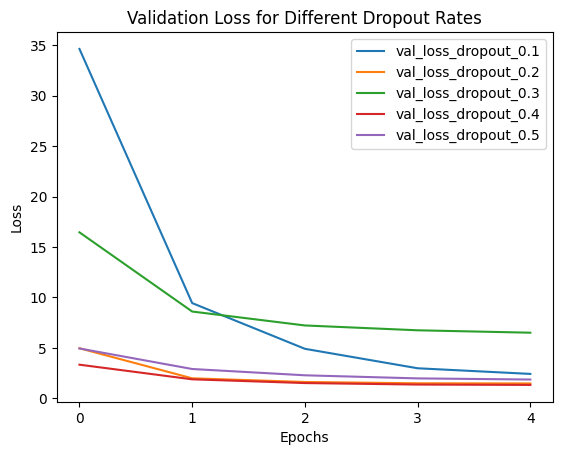

In [47]:
for rate in dropout_rates:
    plt.plot(histories[rate].history['val_loss_val'], label=f"val_loss_dropout_{rate}")

plt.title('Validation Loss for Different Dropout Rates')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(np.arange(5))
plt.show()

In [54]:
# Print classification reports
for dropout_rate, prediction in predictions.items():
    flattened_prediction = prediction.flatten()
    print(f"Classification report for dropout rate {dropout_rate}:")
    print(classification_report(y_test_tokens_flat, flattened_prediction, labels=[0, 1, 2], zero_division=0))
    print()

Classification report for dropout rate 0.1:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    358971
           1       0.97      0.95      0.96    127119
           2       0.80      0.74      0.77     14510

    accuracy                           0.98    500600
   macro avg       0.92      0.90      0.91    500600
weighted avg       0.98      0.98      0.98    500600


Classification report for dropout rate 0.2:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    358971
           1       0.97      0.95      0.96    127119
           2       0.80      0.76      0.78     14510

    accuracy                           0.98    500600
   macro avg       0.92      0.90      0.91    500600
weighted avg       0.98      0.98      0.98    500600


Classification report for dropout rate 0.3:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    35